# transport-network

## Introduction
This notebook calls functions from the repository to build an efficient subway network using a dataset from Paris network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Data 


In [2]:
from data.data_preprocess import df_stations

This dataframe includes the 302 subway stations of the parisian network associated with their geographical localization and their trafic over a year.

In [3]:
df_stations.head(10)

,station,longitude,latitude,traffic
0,ABBESSES,2.338399,48.884400,2417881
1,ALESIA,2.326827,48.828066,5124204
2,ALEXANDRE-DUMAS,2.394554,48.856426,3666961
3,ALMA-MARCEAU,2.301251,48.864299,4204705
4,ANATOLE-FRANCE,2.285517,48.892019,3780611
5,ANVERS,2.344164,48.882872,6432199
6,ARGENTINE,2.289444,48.875672,2972019
7,ARTS-ET-METIERS,2.356108,48.865552,3908721
8,ASNIERES-GENNEVILLIERS LES COURTILLES,2.283761,48.930294,4033364
9,ASSEMBLEE NATIONALE,2.320310,48.861454,1126803


## Building the real network

In [4]:
x = [long for long in df_stations['longitude'].values]
y = [lat for lat in df_stations['latitude'].values]

m = len(df_stations)    

Without any tunnel between the stations, this is what the network looks like :

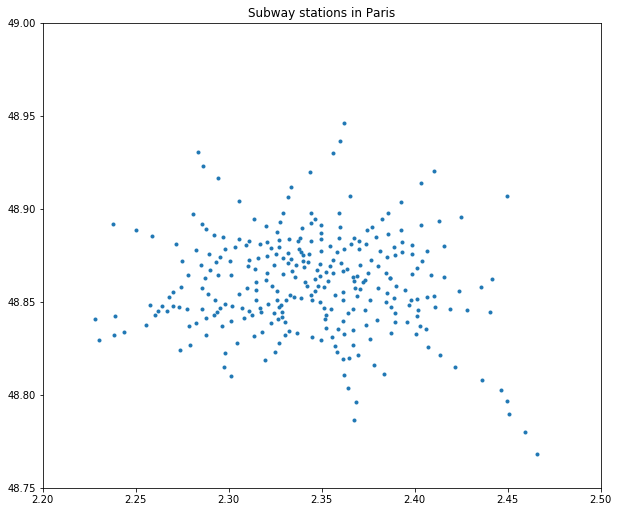

In [5]:
plt.figure(figsize=(10,10)) 
plt.xlim(2.2, 2.5)
plt.ylim(48.75, 49.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x,y,marker='.')
plt.title('Subway stations in Paris')
plt.show()

Then, we import the real Paris network structure which is organized into lines. The file 'real_network.txt' gives us the order through which stations are connected. 'END_OF_LINE' means that the last station was the terminus.

In [6]:
import ast

with open('data/real_network.txt', encoding="utf-8") as file:
    real_network_structure = ast.literal_eval(file.read())

In [7]:
real_network_structure[:30]

['LA DEFENSE',
 'ESPLANADE DE LA DEFENSE',
 'PONT DE NEUILLY',
 'LES SABLONS',
 'PORTE MAILLOT',
 'ARGENTINE',
 'CHARLES DE GAULLE-ETOILE',
 'GEORGE V',
 'FRANKLIN-ROOSEVELT',
 'CHAMPS-ELYSEES-CLEMENCEAU',
 'CONCORDE',
 'TUILERIES',
 'PALAIS-ROYAL',
 'LOUVRE-RIVOLI',
 'CHATELET',
 'HOTEL DE VILLE',
 'SAINT-PAUL',
 'BASTILLE',
 'GARE DE LYON',
 'REUILLY-DIDEROT',
 'NATION',
 'PORTE DE VINCENNES',
 'SAINT-MANDE',
 'BERAULT',
 'CHATEAU DE VINCENNES',
 'END_OF_LINE',
 'PORTE DAUPHINE',
 'VICTOR HUGO',
 'CHARLES DE GAULLE-ETOILE',
 'TERNES']

We are now able to create the adjacency matrix and the adjacency dictionnary of the real network.

In [8]:
from network_building import build_real_network, matrix_to_dic, display_graph

real_network_adj_matrix = build_real_network(real_network_structure)                
real_network_adj_dic = matrix_to_dic(real_network_adj_matrix)

In [9]:
dict(list(real_network_adj_dic.items())[0:10])

{0: [[133, 0.5961277173524393], [198, 0.23524749261568279]],
 1: [[177, 0.5282996716000657], [214, 0.5976274110880769]],
 2: [[12, 0.6412582740723237], [195, 0.41407327885584333]],
 3: [[97, 0.8414500910822615], [116, 0.5271532158865211]],
 4: [[145, 0.35757396589660106], [206, 0.6831478540801342]],
 5: [[14, 0.40276440271516606], [198, 0.5076558670497783]],
 6: [[48, 0.45851728065137026], [233, 0.5725281576443564]],
 7: [[240, 0.5267491130037739],
  [243, 0.27713915305233466],
  [245, 0.5848533850454343],
  [284, 0.42173484224605384]],
 8: [[138, 0.8359608611530541]],
 9: [[64, 0.4507250914949459], [279, 0.38315702796195916]]}

We are now able to display Paris real subway network :

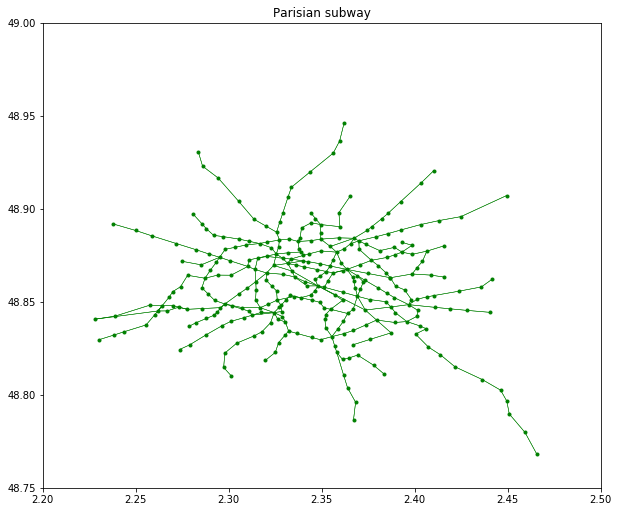

In [10]:
display_graph(real_network_adj_dic, 'Parisian subway')

Now, we compute the building cost and the average travelling time of the real parisian network. It will give us a reference values to compare with. 

In [11]:
from cost import building_cost, average_travelling_time, distance_matrix

Some researches on the Internet show that a good estimate for the building cost of one straight subway kilometer is 120 million euros and for the average speed of a wagon is 25 km/h (counting time for stops).

In [12]:
alpha = 120
V = 25

In [13]:
traffic = df_stations['traffic'].values

In [14]:
real_network_bc = round(building_cost(real_network_adj_dic,alpha)*0.001,2)
real_network_att = round(average_travelling_time(real_network_adj_dic,traffic,V),2)
print("The parisian network cost about", real_network_bc, "billion euros to build and its average travelling time is", real_network_att,"minutes.") 


The parisian network cost about 25.13 billion euros to build and its average travelling time is 15.25 minutes.


In [15]:
round(building_cost(real_network_adj_dic,alpha)*0.001,3)

25.132

## Building the minimum spanning tree

Now that we are able to compute the building cost and the average travelling time of a graph, we are going to build a minimum spanning tree over the 302 stations thanks to the Kruskal's algorithm. 

A minimum spanning tree is a connected graph that doesn't include any cycle. Therefore, it will give us a very good estimate of the optimal building cost for the operator.

First, Kruskal's algorithm requires to sort the edges between two subway stations according to their length. Thus, we build at the same time the distance matrix and the list of all possible edges :

In [16]:
from network_building import sph_distance_coordinate

edges = []
dist_matrix = np.zeros((m,m))
for i in range(m):
    for j in range(i):
        dist_ij = sph_distance_coordinate(x[i], y[i], x[j], y[j])
        dist_matrix[i][j] = dist_ij
        dist_matrix[j][i] = dist_matrix[i][j]
        edges.append([i,j,dist_ij])

In [17]:
edges[:10]

[[1, 0, 6.320974236428022],
 [2, 0, 5.152090275088525],
 [2, 1, 5.874516563730427],
 [3, 0, 3.518064406380761],
 [3, 1, 4.4423618169889005],
 [3, 2, 6.8814481294821235],
 [4, 0, 3.9581386692506837],
 [4, 1, 7.726704530375015],
 [4, 2, 8.902442883552263],
 [4, 3, 3.290072677022877]]

In [18]:
from kruskal import sort_edges, get_MST

Then, we sort the edges and run Kruskal's algorithm to get the minimum spanning tree :

In [19]:
sorted_edges = sort_edges(edges)
kruskal_adj_dic = get_MST(sorted_edges)

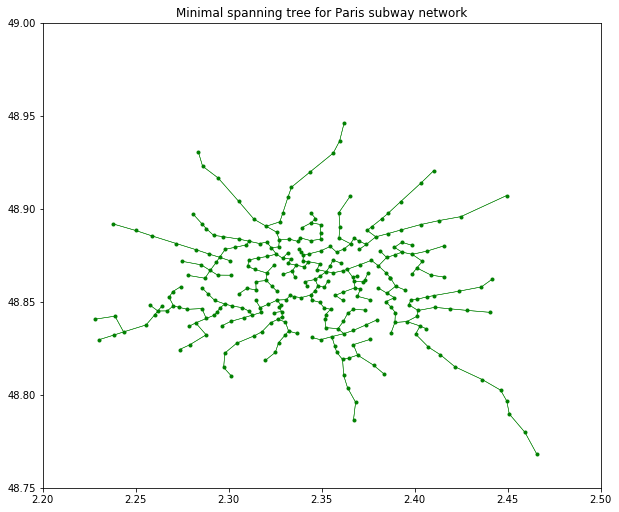

In [20]:
display_graph(kruskal_adj_dic, 'Minimum spanning tree for Paris subway network')

Same as before, we compute the building cost and the average travelling time :

In [21]:
mst_bc = round(building_cost(kruskal_adj_dic,alpha)*0.001,3)
mst_att = round(average_travelling_time(kruskal_adj_dic,traffic,V),2)
print("The minimum spanning tree cost about", mst_bc, "billion euros to build and its average travelling time is", mst_att,"minutes.") 

The minimal spanning tree cost about 18.5 billion euros to build and its average travelling time is 23.0 minutes.


## A simple heuristic to improve the spanning tree

Now that we have a connected graph, we can run the heuristic described in the paper to add the good edges :

In [23]:
from strategy import heuristic

The following code is the main part of the solution. It might take a few minutes to run...

In [24]:
heuristic_adj_dic, added_edges = heuristic(kruskal_adj_dic, 25, sorted_edges, alpha,traffic,V)

The edge [248, 239, 0.36974209853827544] was added to the graph.
The building cost has increased by 44.36905182459305 euros and is now 18.499671823947295.
The edge [275, 89, 0.4177930239308437] was added to the graph.
The building cost has increased by 50.13516287170125 euros and is now 18.544040875771888.
The edge [262, 198, 0.4277698579271627] was added to the graph.
The building cost has increased by 51.332382951259525 euros and is now 18.59417603864359.
The edge [276, 271, 0.4421007669644895] was added to the graph.
The building cost has increased by 53.052092035738745 euros and is now 18.645508421594847.
The edge [111, 39, 0.4738315879461378] was added to the graph.
The building cost has increased by 56.859790553536534 euros and is now 18.698560513630586.
The edge [248, 57, 0.48665235867659334] was added to the graph.
The building cost has increased by 58.3982830411912 euros and is now 18.755420304184124.
The edge [104, 51, 0.492454506385979] was added to the graph.
The building c

The edge [229, 65, 0.8275488257510417] was added to the graph.
The building cost has increased by 99.30585909012501 euros and is now 22.765559942511448.
The edge [218, 78, 0.8214700572053861] was added to the graph.
The building cost has increased by 98.57640686464633 euros and is now 22.864865801601574.
The edge [95, 7, 0.8253234884509266] was added to the graph.
The building cost has increased by 99.0388186141112 euros and is now 22.963442208466216.
The edge [97, 3, 0.8414500910822615] was added to the graph.
The building cost has increased by 100.97401092987138 euros and is now 23.062481027080324.
The edge [184, 59, 0.8485092205856803] was added to the graph.
The building cost has increased by 101.82110647028165 euros and is now 23.1634550380102.
The edge [265, 200, 0.8453778328854471] was added to the graph.
The building cost has increased by 101.44533994625365 euros and is now 23.265276144480477.
The edge [59, 21, 0.8548972371318324] was added to the graph.
The building cost has i

We can now plot our new network. The red edges are the ones that were added by our heuristic.

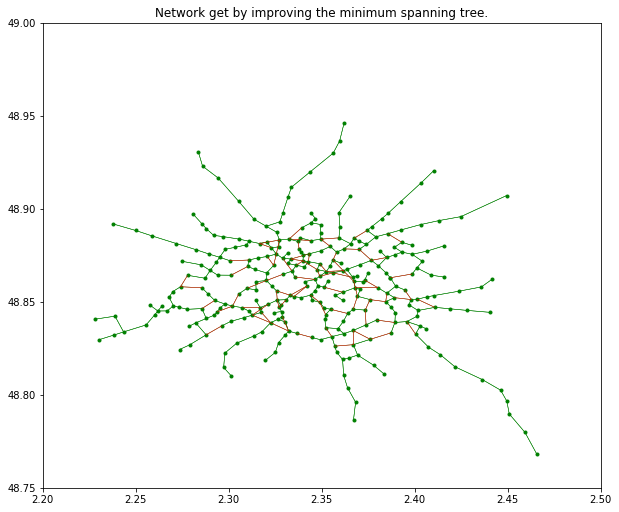

In [27]:
display_graph(heuristic_adj_dic, "Network get by improving the minimum spanning tree.", special_edges=added_edges)

Same as before, we compute the building cost and the average travelling time :

In [29]:
heuristic_bc = round(building_cost(heuristic_adj_dic,alpha)*0.001,3)
heuristic_att = round(average_travelling_time(heuristic_adj_dic,traffic,V),2)
print("The new network cost about", heuristic_bc, "billion euros to build and its average travelling time is", heuristic_att,"minutes.") 

The new network cost about 25.048 billion euros to build and its average travelling time is 15.28 minutes.


Awesome ! Starting from the minimum spanning tree, we succeeded in founding a network very close to the real Parisian subway. We could iterate the heuristic with a higher maximum building cost to find an even more effective network but it would take more time to run.